In [1]:
import pandas as pd
import numpy as np
# https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset
df = pd.read_csv('/content/drive/MyDrive/colab_datasets/YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


In [3]:
df.isnull().sum()

,0
Comment,44
Sentiment,0


In [4]:
df['Sentiment'].value_counts()

,count
Sentiment,
positive,11432
neutral,4638
negative,2338


In [5]:
df_negative = df[df["Sentiment"] == "negative"]
df_neutral  = df[df["Sentiment"] == "neutral"].sample(n=2338, random_state=42)
df_positive = df[df["Sentiment"] == "positive"].sample(n=2338, random_state=42)
df = pd.concat([df_negative, df_neutral, df_positive])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,2338
negative,2338
positive,2338


In [7]:
df = df.dropna(subset=["Comment"])

In [8]:
df.isnull().sum()

,0
Comment,0
Sentiment,0


In [9]:
import re
import html

def clean_comment(text):
    text = html.unescape(text)                            # HTML сущности
    text = re.sub(r"http\S+", "", text)                   # Удалить ссылки
    text = re.sub(r"@\w+", "", text)                      # Удалить упоминания
    text = re.sub(r"#\w+", "", text)                      # Удалить хэштеги
    text = re.sub(r"\s+", " ", text).strip()              # Убрать лишние пробелы
    return text

In [10]:
df['Comment'] = df['Comment'].apply(clean_comment)

In [11]:
df.head()

,Comment,Sentiment
0,women may have brought men into the world but ...,neutral
1,this is where i play my reverse uno card,neutral
2,2nd meme i have tainted such an innocent soul,negative
3,this is soo true but the real situation is eve...,negative
4,real republicans would feel their skin crawl l...,negative


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

texts = df["Comment"].tolist()
labels = df["Sentiment"].tolist()

le = LabelEncoder()
labels = le.fit_transform(labels)  # 0 = negative, 1 = neutral, 2 = positive

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [13]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
print("UNIQUE LABELS:", set(train_labels))
print("TYPE:", type(train_labels[0]))

UNIQUE LABELS: {np.int64(0), np.int64(1), np.int64(2)}
TYPE: <class 'numpy.int64'>


In [15]:
train_labels = [int(x) for x in train_labels]
val_labels = [int(x) for x in val_labels]

In [16]:
import torch

class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CommentDataset(train_encodings, train_labels)
val_dataset = CommentDataset(val_encodings, val_labels)

In [17]:
print("UNIQUE LABELS:", set(train_labels))
print("TYPE:", type(train_labels[0]))

UNIQUE LABELS: {0, 1, 2}
TYPE: <class 'int'>


In [18]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.512700,0.561757
2,0.364800,0.475145
3,0.190900,0.507123


TrainOutput(global_step=264, training_loss=0.4129534941731077, metrics={'train_runtime': 51.2789, 'train_samples_per_second': 327.503, 'train_steps_per_second': 5.148, 'total_flos': 556174291659264.0, 'train_loss': 0.4129534941731077, 'epoch': 3.0})

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82       468
     neutral       0.74      0.77      0.75       466
    positive       0.89      0.87      0.88       466

    accuracy                           0.81      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.81      0.82      1400



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


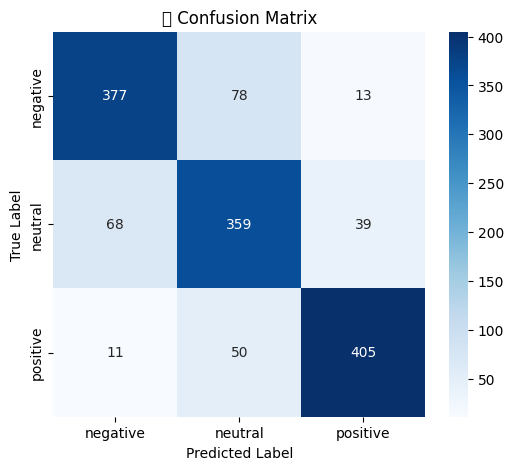

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
label_names = le.classes_

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧠 Confusion Matrix")
plt.show()


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6998 entries, 0 to 7013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    6998 non-null   object
 1   Sentiment  6998 non-null   object
dtypes: object(2)
memory usage: 164.0+ KB


In [21]:
df['Sentiment'].value_counts()

,count
Sentiment,
negative,2337
neutral,2332
positive,2329


In [22]:
df.shape

(6998, 2)

In [28]:
# bert-large-uncased - Тяжёлая модель, лучше использовать на большом датасете
# roberta-base - Очень сильная модель. Улучшенный BERT
# roberta-large - Тяжёлая, но максимально точная
# microsoft/deberta-v3-base - Точнее BERT и RoBERTa в большинстве классификаций. SOTA модель
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

MODEL_NAME2 = "microsoft/deberta-v3-base"
tokenizer2 = AutoTokenizer.from_pretrained(MODEL_NAME2)

train_encodings2 = tokenizer2(train_texts, truncation=True, padding=True, max_length=128)
val_encodings2 = tokenizer2(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [29]:
import torch

class CommentDataset2(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, index):
        item = {k: torch.tensor(v[index]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[index]), dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_dataset2 = CommentDataset2(train_encodings2, train_labels)
val_dataset2 = CommentDataset2(val_encodings2, val_labels)

In [30]:
import os
os.environ["WANDB_DISABLED"] = "true"

model2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME2, num_labels=3)
training_args2 = TrainingArguments(
    output_dir="./results2",
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs2",
    logging_steps=10,
    report_to="none",
    fp16=True,
)

trainer2 = Trainer(
    model = model2,
    args = training_args2,
    train_dataset = train_dataset2,
    eval_dataset = val_dataset2,
)
trainer2.train()

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.455700,0.617187
2,0.355400,0.418284
3,0.183600,0.473828
4,0.124300,0.553983
5,0.098600,0.641012


TrainOutput(global_step=440, training_loss=0.3048277986320582, metrics={'train_runtime': 290.5962, 'train_samples_per_second': 96.319, 'train_steps_per_second': 1.514, 'total_flos': 1841169158899200.0, 'train_loss': 0.3048277986320582, 'epoch': 5.0})

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.90      0.88       468
     neutral       0.79      0.75      0.77       466
    positive       0.88      0.88      0.88       466

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400



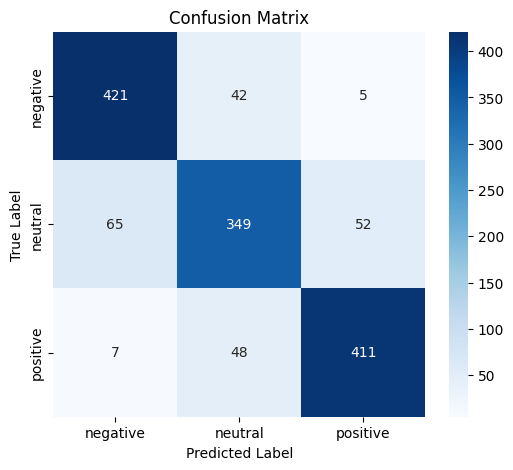

In [31]:
predictions2 = trainer2.predict(val_dataset2)
y_pred2=np.argmax(predictions2.predictions, axis=1)
y_true2=predictions2.label_ids
label_names2=le.classes_

print("📊 Classification Report:")
print(classification_report(y_true2, y_pred2, target_names=label_names2))

cm2 = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names2, yticklabels=label_names2)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
#The model has been overtrained, this can be seen from the results of Training Loss and Validation Loss,
#we can conclude that 3 epochs are enough.